In [1]:
import os
import subprocess
import bt
import datetime as dt

tickers = subprocess.run(args=["python", os.getcwd() + "\\portfolio_allocation.py"],text=True,stdout=subprocess.PIPE)

results = tickers.stdout.strip('""[]\n').split(', ')

symbols = [element.strip("'\"") for element in results]

current_date = dt.date.today()
start_date = current_date - dt.timedelta(days=365)
start = (start_date - dt.timedelta(days=round((1.5*50)-1,0)))

if start.isoweekday() == 6:
    start = start - dt.timedelta(days=1)
elif start.isoweekday() == 7:
    start = start + dt.timedelta(days=1)


df = bt.get(symbols,start=start.strftime("%Y-%m-%d"))

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [3]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_torus(ticker,big,rolling_mean,rolling_std,buy_signal,sell_signal,size):
    # Define parametric equations for a torus
    def torus_parametric(u, v, R, r):
        x = (R + r * np.cos(v)) * np.cos(u)
        y = (R + r * np.cos(v)) * np.sin(u)
        z = r * np.sin(v)
        return x, y, z

    # Parameters for the torus
    R = (rolling_mean[ticker] + (2 * rolling_std[ticker])).mean()  # Major radius
    r = rolling_mean[ticker].mean()  # Minor radius

    # Generate torus coordinates
    u = np.linspace(0,big,size)
    v = np.linspace(0,big,size)
    U, V = np.meshgrid(u, v)
    X, Y, Z = torus_parametric(U, V, R, r)

    # Plot the torus
    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, alpha=0.1, cmap='viridis')

    # Plot the price data
    ax.scatter(X[buy_signal[ticker]], Y[buy_signal[ticker]], Z[buy_signal[ticker]], color='g', label='Buy Signal')
    ax.scatter(X[sell_signal[ticker]], Y[sell_signal[ticker]], Z[sell_signal[ticker]], color='r', label='Sell Signal')
    ax.tick_params(labelsize=10)
    
    plt.show()

def action_tickers(ticker,buy_indicator,sell_indicator):
    tick_buy = pd.DataFrame(buy_indicator[ticker])
    tick_buy["BuySignal"] = "Buy"
    tick_buy = tick_buy.rename(columns={ticker:"BuyAction"})

    tick_sell = pd.DataFrame(sell_indicator[ticker])
    tick_sell["SellSignal"] = "Sell"
    tick_sell = tick_sell.rename(columns={ticker:"SellAction"})

    actions = pd.concat([tick_buy,tick_sell],axis=1)
                     
    actions.loc[(actions["BuyAction"] == False) & (actions["SellAction"] == False), ["BuySignal","SellSignal"]] = "Hold"

    buy = actions.loc[(actions["BuySignal"] == "Buy") & (actions["BuyAction"] == True), "BuySignal"]
    sell = actions.loc[(actions["SellSignal"] == "Sell") & (actions["SellAction"] == True), "SellSignal"]
    hold = actions.loc[(actions["BuySignal"] == "Hold") & (actions["SellSignal"] == "Hold"), "BuySignal"]

    actions = pd.concat([buy,sell,hold],axis=0).reset_index()

    actions.columns = ["Date", ticker + "Signal"]

    actions = actions.sort_values(by="Date",ascending=True).reset_index(drop=True)

    actions = actions.drop(["Date"],axis=1)

    return actions


big = 2 * np.pi
df_filter = (df - df.loc[df.index.date == start_date].values)

# Calculate the mean and standard deviation 

rolling_mean = df_filter.rolling(window=50).mean()
rolling_std = df_filter.rolling(window=50).std()

buy_signal = df_filter < rolling_mean - (2 * rolling_std)
sell_signal = df_filter > rolling_mean + (2 * rolling_std)

buy_signal = buy_signal.loc[buy_signal.index.date >= start_date]
sell_signal = sell_signal.loc[sell_signal.index.date >= start_date]

ticker_action = pd.DataFrame(buy_signal.index)

for tick in symbols:
    ticker_action[tick.lower() + "Signal"] = action_tickers(tick.lower(),buy_signal,sell_signal)

date = ticker_action.pop("Date")
ticker_action = ticker_action.set_index(date)

ticker_action

ValueError: Unable to coerce to DataFrame, shape must be (303, 12): given (0, 12)

In [ ]:
plot_torus("cvx",big,rolling_mean.loc[rolling_mean.index >= start_date.strftime("%Y-%m-%d")],
           rolling_std.loc[rolling_std.index >= start_date.strftime("%Y-%m-%d")],buy_signal,sell_signal,len(ticker_action))

In [ ]:
def action_tickers(ticker,buy_indicator,sell_indicator):
    tick_buy = pd.DataFrame(buy_indicator[ticker])
    tick_buy["BuySignal"] = "Buy"
    tick_buy = tick_buy.rename(columns={ticker:"BuyAction"})

    tick_sell = pd.DataFrame(sell_indicator[ticker])
    tick_sell["SellSignal"] = "Sell"
    tick_sell = tick_sell.rename(columns={ticker:"SellAction"})

    actions = pd.concat([tick_buy,tick_sell],axis=1)
                     
    actions.loc[(actions["BuyAction"] == False) & (actions["SellAction"] == False), ["BuySignal","SellSignal"]] = "Hold"

    buy = actions.loc[(actions["BuySignal"] == "Buy") & (actions["BuyAction"] == True), "BuySignal"]
    sell = actions.loc[(actions["SellSignal"] == "Sell") & (actions["SellAction"] == True), "SellSignal"]
    hold = actions.loc[(actions["BuySignal"] == "Hold") & (actions["SellSignal"] == "Hold"), "BuySignal"]

    actions = pd.concat([buy,sell,hold],axis=0).reset_index()

    actions.columns = ["Date", ticker + "Signal"]

    actions = actions.sort_values(by="Date",ascending=True).reset_index(drop=True)

    actions = actions.drop(["Date"],axis=1)

    return actions

ticker_action = pd.DataFrame(df.index)

for tick in symbols:
    ticker_action[tick.lower() + "Signal"] = action_tickers(tick.lower(),buy_signal,sell_signal)

date = ticker_action.pop("Date")
ticker_action = ticker_action.set_index(date)

ticker_action

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

tailAction


0% [############################# ] 100% | ETA: 00:00:00

<Axes: title={'center': 'Equity Progression'}>

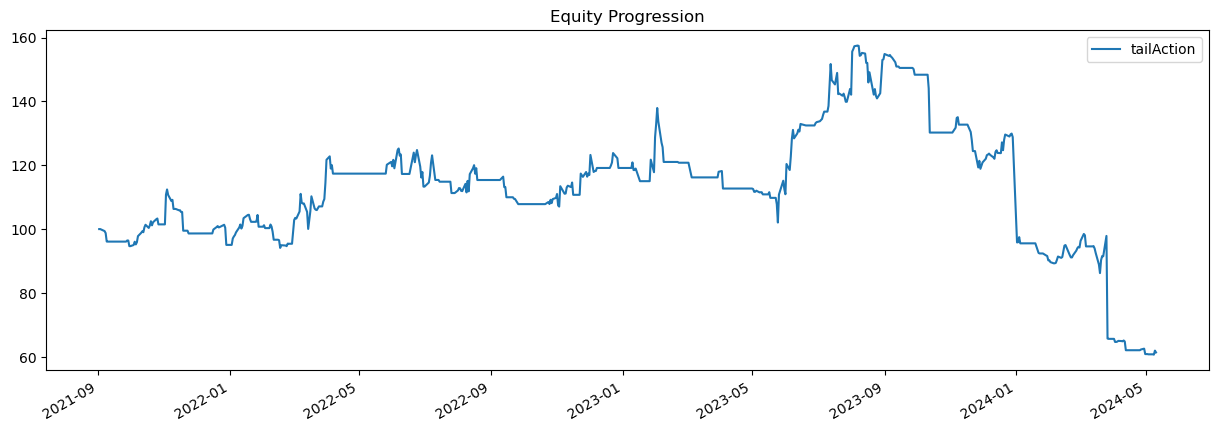

In [1]:
import os
import subprocess
import bt
import datetime as dt
import numpy as np
import json

criteria = json.loads(open(os.getcwd() + "\\criteria.json","r").read())

tickers = subprocess.run(args=["python", os.getcwd() + "\\data_cleaning.py"],text=True,stdout=subprocess.PIPE)

results = tickers.stdout.strip('""[]\n').split(', ')

symbols = [element.strip("'\"") for element in results]

# current_date = dt.date.today()
# start_date = current_date - dt.timedelta(days=2000)

# num_day = start_date.isoweekday()

# if num_day > 5:
#     start_date = start_date - dt.timedelta(days=num_day-5)

# start = start_date - dt.timedelta(days=round((1.5*50)-1,0))

# if start.isoweekday() == 6:
#     start = start - dt.timedelta(days=1)
# elif start.isoweekday() == 7:
#     start = start + dt.timedelta(days=1)

df = bt.get(symbols,start="2014-01-01")

df_filter = df - df.iloc[0,:].values

norm_price = ((df_filter - df_filter.min()) / (df_filter.max()-df_filter.min())) * (2*np.pi)

rolling_mean = norm_price.rolling(window=50).mean()
rolling_std = norm_price.rolling(window=50).std()

buy_signal = norm_price < rolling_mean - (2 * rolling_std)
sell_signal = norm_price > rolling_mean + (2 * rolling_std)

# bt.algos.WeighSpecified(**weights)


strat = bt.Strategy('tailAction', [bt.algos.SelectWhere(sell_signal),
                                   bt.algos.WeighEqually(),
                                   bt.algos.Rebalance()])

# now we create the Backtest
t = bt.Backtest(strat, df.iloc[51:,:],integer_positions=False, progress_bar=True)

# and let's run it!
res = bt.run(t)

res.plot()


tailAction
0% [#                             ] 100% | ETA: 00:00:00

0% [############################# ] 100% | ETA: 00:00:00

<Axes: title={'center': 'Equity Progression'}>

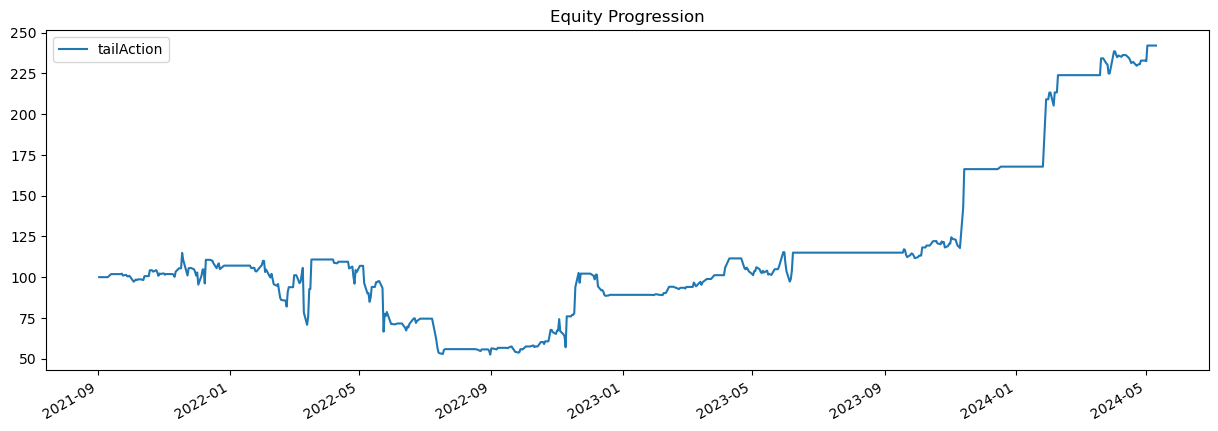

In [2]:
import bt


strat = bt.Strategy('tailAction', [bt.algos.SelectWhere(buy_signal),
                                   bt.algos.WeighEqually(),
                                   bt.algos.Rebalance()])

# now we create the Backtest
t = bt.Backtest(strat, df.iloc[51:,:],integer_positions=False, progress_bar=True)

# and let's run it!
res = bt.run(t)

res.plot()

In [4]:
import bt

strat = bt.Strategy('tailAction', [bt.algos.SelectWhere(sell_signal),
                                   bt.algos.SelectWhere(buy_signal),
                                   bt.algos.WeighEqually(),
                                   bt.algos.Rebalance()])

# now we create the Backtest
t = bt.Backtest(strat, df,integer_positions=False, progress_bar=True)

# and let's run it!
res = bt.run(t)

res.plot()

,cdlx,cvx,pypl,mod,calm,inda,anf,ymm,cort,dlo,gntx,incy
Date,,,,,,,,,,,,
2021-06-23,False,False,False,False,False,False,False,False,False,False,False,False
2021-06-24,False,False,False,False,False,False,False,False,False,False,False,False
2021-06-25,False,False,False,False,False,False,False,False,False,False,False,False
2021-06-28,False,False,False,False,False,False,False,False,False,False,False,False
2021-06-29,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-06,False,False,False,False,False,False,False,False,False,False,False,False
2024-05-07,False,False,False,True,False,False,False,False,False,False,False,False
2024-05-08,False,False,False,True,False,False,False,False,False,False,False,False
